# Задача 9. Hand-crafted graph features
- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install networkx
!pip install numpy
!pip install scikit-learn

## Датасет
В качестве датасета был выбран PROTEINS - набор белков, где каждый белок представляет собой граф и классифицируется как фермент или нефермент. Узлы представляют аминокислоты, и два узла соединяются ребром, если они находятся на расстоянии менее 6 ангстрем друг от друга.

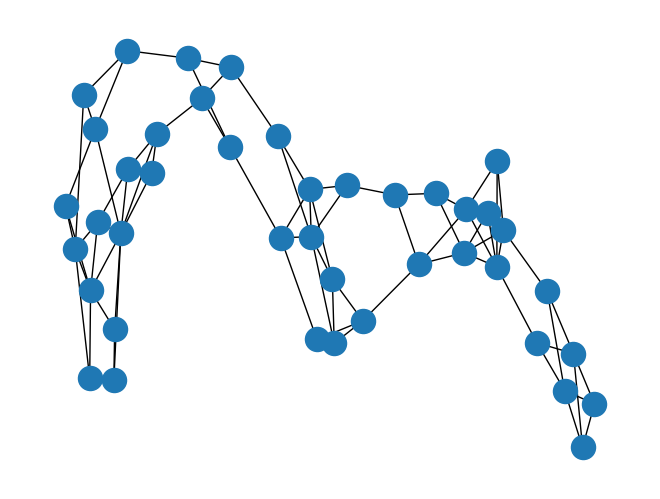

In [135]:
import networkx as nx
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

root_dir = "data"
dataset = TUDataset(root=root_dir, name="PROTEINS")

graphs = [to_networkx(d, to_undirected=True) for d in dataset]
n = len(graphs)
y = [int(d.y) for d in dataset]

nx.draw(graphs[0])

## Подготовка данных

In [136]:
seed = 123
np.random.seed(seed)

# max vector dimension
max_length = 0
for G in graphs:
    for comp in nx.connected_components(G):
        subG = G.subgraph(comp)
        max_length = max(max_length, nx.diameter(subG))

train_ids, test_ids = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    random_state=seed,
    stratify=y
)

X_train = [graphs[i] for i in train_ids]
X_test = [graphs[i] for i in test_ids]
y_train = [y[i] for i in train_ids]
y_test =  [y[i] for i in test_ids]

## Матрицы ядровых функций, количество кратчайших путей различной длины

In [137]:
def convert_graphs(gs):
    all_lengths = []
    converted = np.zeros((len(gs), max_length))
    for G in gs:
        current_g_lengths = {}
        for v, shortest_paths in nx.shortest_path_length(G):
            for u, u_len in shortest_paths.items():
                if v < u:  # avoid duplicates and ingnore "0" distance
                    current_g_lengths[u_len] = current_g_lengths.get(u_len, 0) + 1
        all_lengths.append(current_g_lengths)

        for i, shortest_paths in enumerate(all_lengths):
            for length, cnt in shortest_paths.items():
                converted[i, length - 1] = cnt
    return converted

X_train = convert_graphs(X_train)
X_test = convert_graphs(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

K_train = np.dot(X_train, X_train.T)
K_test = np.dot(X_test, X_train.T)

print(K_train.shape, K_test.shape)

(890, 890) (223, 890)


## Обучение модели и перебор гиперпараметров

In [138]:
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score,
                             accuracy_score)

model = SVC(kernel='precomputed', random_state=seed)

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 10]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy"
)

grid_search.fit(K_train, y_train)

best_model = grid_search.best_estimator_

Метрики качества

In [139]:
y_pred = best_model.predict(K_test)
sp_accuracy_score = accuracy_score(y_test, y_pred)
sp_precision_score = precision_score(y_test, y_pred)
sp_recall_score = recall_score(y_test, y_pred)
sp_f1_score = f1_score(y_test, y_pred)

print("Accuracy:", sp_accuracy_score)
print("Precision:", sp_precision_score)
print("Recall:", sp_recall_score)
print("F1 score:", sp_f1_score)

Accuracy: 0.7443946188340808
Precision: 0.6853932584269663
Recall: 0.6777777777777778
F1 score: 0.6815642458100558


Дополнительно создадим тривиальный классификатор, который всегда будет возвращать наиболее часто встречающийся класс

In [140]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=seed)
dummy.fit(X_train, y_train)

dummy_acc = dummy.score(X_test, y_test)
print("Accuracy with dummy (most frequent) classifier:", dummy_acc)

Accuracy with dummy (most frequent) classifier: 0.5964125560538116


Сравним результаты, получили, что наш обученный выигрывает по метрике accurancy:

In [141]:
print("With SVC accuracy:", sp_accuracy_score)
print("Accuracy with dummy (most frequent) classifier:", dummy_acc)

With SVC accuracy: 0.7443946188340808
Accuracy with dummy (most frequent) classifier: 0.5964125560538116


## Weisfeiler-Lehman Kernel


In [142]:
h = 2 # Я перебрал значения h из диапазона [2, 4] и лучше всего себя показала модель с h=2

result = [[] for _ in range(n)]
for i, G in enumerate(graphs):
    nodes_count = G.number_of_nodes()
    node_labels = [1 for _ in range(nodes_count)]
    keys_mapping = {frozenset({1: 1}): 1}
    max_label = 2
    for j in range(0, h):
        # compute intermediate representation
        next_keys = [{} for _ in range(nodes_count)]
        for v in range(nodes_count):
            v_labels = next_keys[v]
            for neighbor in G.neighbors(v):
                neighbor_label = node_labels[neighbor]
                if neighbor_label not in v_labels:
                    v_labels.setdefault(neighbor_label, 0)
                v_labels[neighbor_label] += 1
        # updates mapping
        for v, v_key in enumerate(next_keys):
            v_key = frozenset(v_key.items())
            if v_key not in keys_mapping:
                keys_mapping[v_key] = max_label
                max_label += 1
            node_labels[v] = keys_mapping[v_key]
    result[i] = node_labels

mapping2 = {}
all_values = set()
mx = 0
for i in range(n):
    for j in range(graphs[i].number_of_nodes()):
        all_values.add(result[i][j])
        mx = max(mx, result[i][j])
all_values = list(sorted(all_values))

for i, value in enumerate(all_values):
    mapping2.setdefault(value, i)

converted_graphs = np.zeros((n, mx))

for i in range(n):
    count = np.zeros(mx)
    for value in result[i]:
        count[mapping2[value]] += 1
    converted_graphs[i] = count

In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    converted_graphs,
    y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

K_train = np.dot(X_train, X_train.T)
K_test = np.dot(X_test, X_train.T)

#verify shape
print(K_train.shape, K_test.shape)

(890, 890) (223, 890)


## Обучение

In [144]:
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score,
                             accuracy_score)

model = SVC(kernel='precomputed', random_state=seed)

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 10]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy"
)

grid_search.fit(K_train, y_train)

best_model = grid_search.best_estimator_

## Метрики

In [145]:
y_pred = best_model.predict(K_test)
wsl_accuracy_score = accuracy_score(y_test, y_pred)
wsl_precision_score = precision_score(y_test, y_pred)
wsl_recall_score = recall_score(y_test, y_pred)
wsl_f1_score = f1_score(y_test, y_pred)

print("Accuracy:", wsl_accuracy_score)
print("Precision:", wsl_precision_score)
print("Recall:", wsl_recall_score)
print("F1 score:", wsl_f1_score)

Accuracy: 0.726457399103139
Precision: 0.6986301369863014
Recall: 0.5666666666666667
F1 score: 0.6257668711656442


## Результаты

In [ ]:
!pip install pandas

In [147]:
import pandas as pd

metrics = {
    'Shortest paths': {
        'accuracy': sp_accuracy_score,
        'precision': sp_precision_score,
        'recall': sp_precision_score,
        'f1': sp_precision_score,
    },
    'Weisfeiler-Lehman': {
        'accuracy':wsl_accuracy_score,
        'precision': wsl_precision_score,
        'recall': wsl_recall_score,
        'f1': wsl_f1_score,
    },
}

df = pd.DataFrame.from_dict(metrics, orient='index')

print(df)

                   accuracy  precision    recall        f1
Shortest paths     0.744395   0.685393  0.685393  0.685393
Weisfeiler-Lehman  0.726457   0.698630  0.566667  0.625767


Мы видим, что обе реализации ядра сравнимы по precision, но по остальным метрикам выигрывает ядро Shortest-paths